# Titanic: Machine Learning from Disaster

**Задача** - провести анализ и понять какое категории людей имели большие шансы выжить. Необходимо предсказать выживет ли пассажир или нет.

**Метрика** - сабмиты оцениваются по доле верных предсказаний - accuracy.

## 1. EDA (Разведочный анализ данных, Exploratory data analysis)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

Считываем тренировочные данные:

In [2]:
train_data = pd.read_csv("../data/input/train.csv", index_col="PassengerId")
test_data = pd.read_csv("../data/input/test.csv", index_col="PassengerId")
print(f"Shape of train data: {train_data.shape}. Shape of test data: {test_data.shape}")

Shape of train data: (891, 11). Shape of test data: (418, 10)


In [3]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Описание признаков

In [4]:
train_data.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


#### Краткое описание:
- Survived - целевая метка, 0 - не выжил, 1 - выжил
- Pclass - класс билетов, 1 - первый, 2 - второй, 3 - третий
- Name - имя - из этого признака попробуем извлечь полезную иформацию
- Sex - пол
- Age - возраст, лет
- SibSp - количество братьев/сестер/супругов на корабле
- Parch - количество родителей/детей на корабле
- Ticket - номер билета
- Fare - транспортные расходы либо пассажирский тариф
- Cabin - номер каюты - можно попробовать использовать в фича-инжинеринге для определения месторасположения каюты в пределах корабля
- Embarked - порт погрузки

Создадим два списка признаков, соответствующие их группам: числовые и категориальные.

In [21]:
num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = train_data.columns.drop(num_features).drop(['Survived', 'Name', 'Ticket']).tolist()
text_features = ['Name']
print(f'Числовые признаки: {num_features}')
print(f'Номинальные признаки: {cat_features}')
print(f'Текстовые признаки: {text_features}')

Числовые признаки: ['Age', 'SibSp', 'Parch', 'Fare']
Номинальные признаки: ['Pclass', 'Sex', 'Cabin', 'Embarked']
Текстовые признаки: ['Name']


### Анализируем целевую переменную

In [7]:
train_data['Survived'].describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

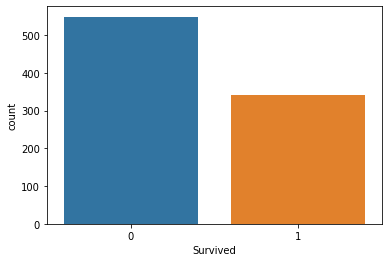

In [7]:
sns.countplot(x='Survived', data=train_data)

In [8]:
print ('Выживаемость = {0:.3f}'.format(train_data.Survived.sum()/train_data.shape[0]))

Выживаемость = 0.384


**Корелляция с признаками**

In [9]:
def print_percentage(df,col_name,col_values):
    for x in col_values:
        group = df.loc[df[col_name]==x]
        print ('{0} survival rate: {1:.3f}'.format(x, (group['Survived'].sum()/group.shape[0])))

In [10]:
def rand_jitter(arr,factor,limit):
    r = arr.max()-arr.min()
    stdev = factor*r
    arr = arr + np.random.randn(arr.shape[0]) * stdev
    arr = arr.clip(arr.min()-limit,arr.max()+limit)
    return arr

**Пол**

male survival rate: 0.189
female survival rate: 0.742


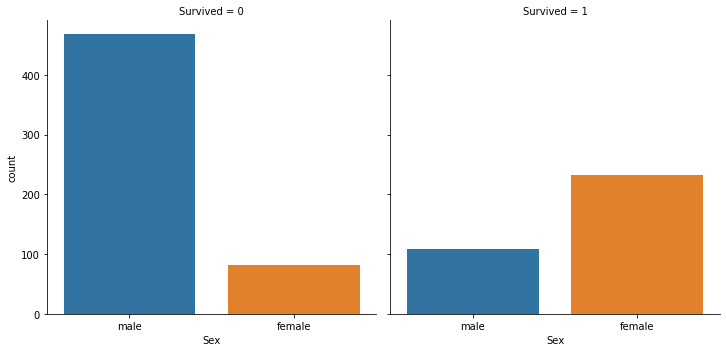

In [11]:
sns.catplot(x='Sex', col='Survived', kind='count', data=train_data)
print_percentage(train_data,'Sex',['male','female'])

**Класс билетов**

1 survival rate: 0.630
2 survival rate: 0.473
3 survival rate: 0.242


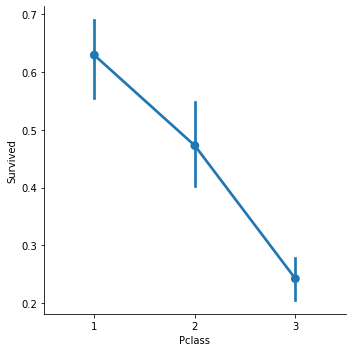

In [12]:
sns.catplot('Pclass', 'Survived', kind='point', data=train_data)
print_percentage(train_data,'Pclass',[1,2,3])

**Пол+класс билетов**

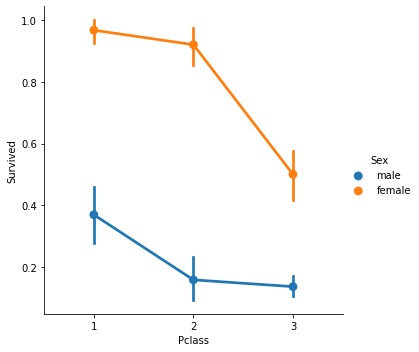

In [13]:
sns.catplot('Pclass', 'Survived', hue='Sex', kind='point', data=train_data)

In [15]:
# train_data['Sex'] = train_data['Sex'].astype('category')
# train_data['sex'] = rand_jitter(train_data['Sex'].cat.codes,0.07,0.4)
# train_data['pclass'] = rand_jitter(train_data['Pclass'],0.07,0.4)
# plt.figure(figsize=(16, 6))
# seaborn.scatterplot(x="sex",y="pclass",hue="Survived",data=train_data)

**Порт погрузки**

S survival rate: 0.337
C survival rate: 0.554
Q survival rate: 0.390


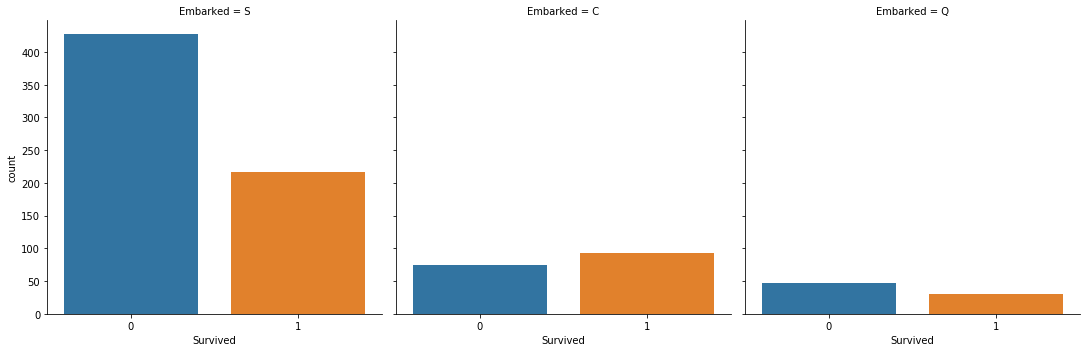

In [14]:
sns.catplot(x='Survived', col='Embarked', kind='count', data=train_data)
print_percentage(train_data,'Embarked',['S','C','Q'])

### Анализ признаков

**Пропуски в данных** - Вынести как функцию в отдельный модуль!!!!!!!!

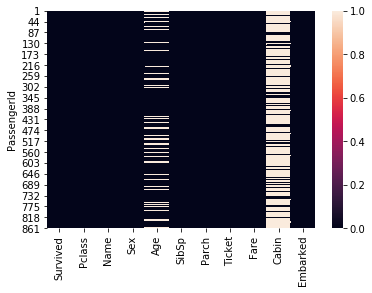

In [15]:
sns.heatmap(train_data.isnull())

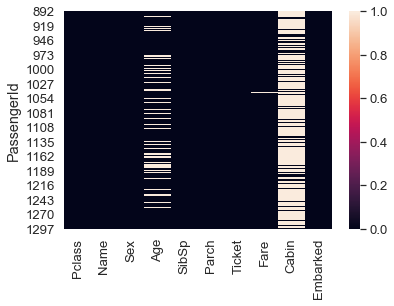

In [22]:
sns.heatmap(test_data.isnull())

In [29]:
print(f'Пропуски данных в трейн датасете:\n{train_data.isnull().sum()}\n' + "-"*30)
print(f'Пропуски данных в тестовом датасете:\n{test_data.isnull().sum()}\n' + "-"*30)

Пропуски данных в трейн датасете:
Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64
------------------------------
Пропуски данных в тестовом датасете:
Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64
------------------------------


**Обзор признаков**

C:\Users\nikita\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\nikita\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\nikita\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\nikita\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


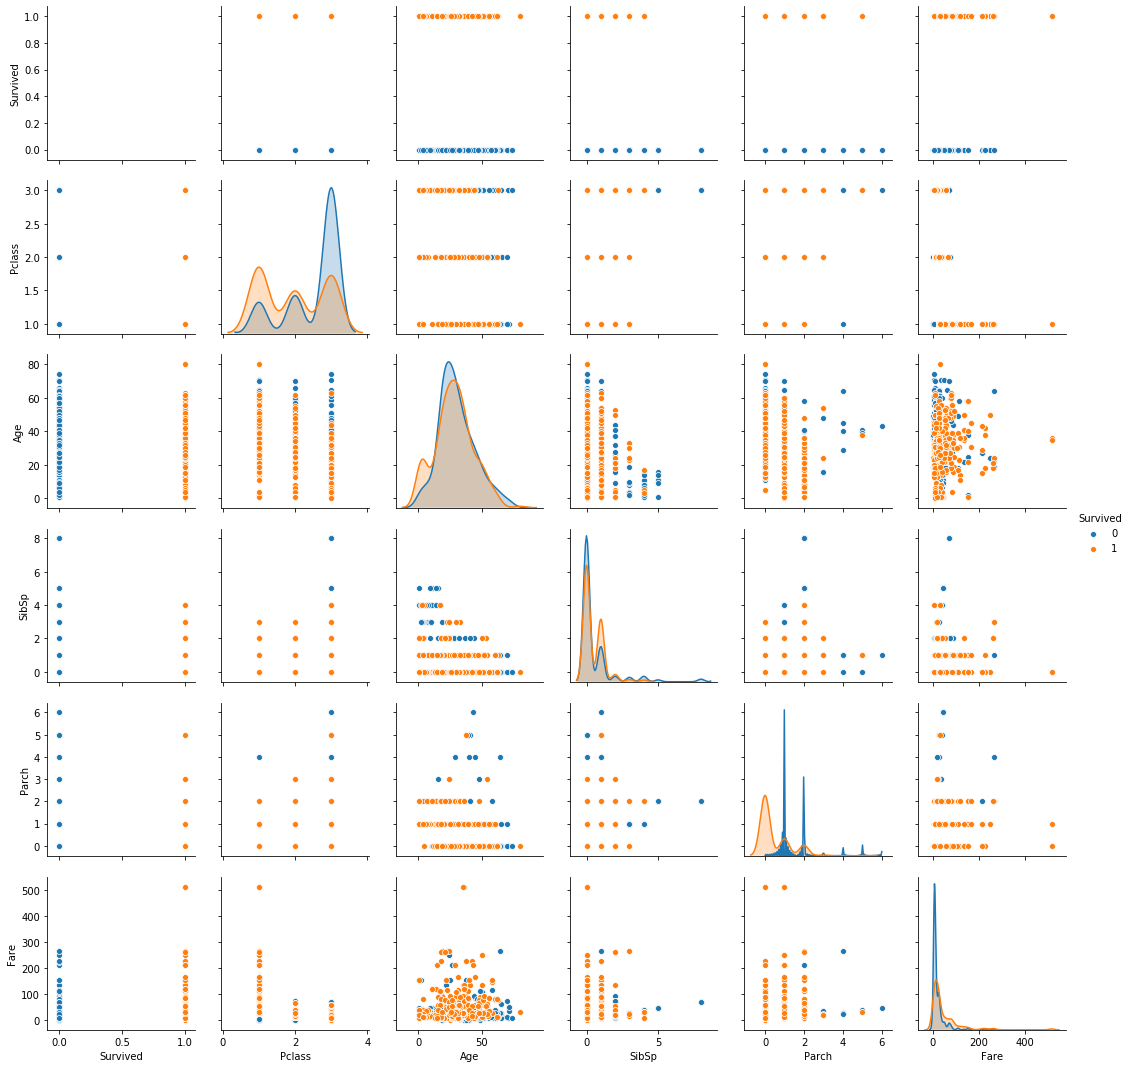

In [16]:
sns.pairplot(train_data, hue="Survived")

**Транспортные расходы**

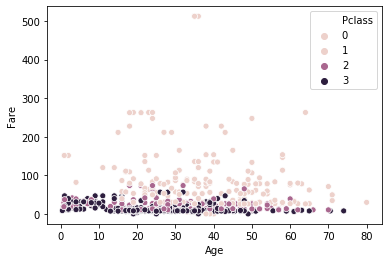

In [17]:
sns.scatterplot(x="Age", y="Fare", hue = 'Pclass', data=train_data)

Можно сделать вывод о том, что расходы более 500 являются выбросами

**Строим матрицу корреляции признаков между собой**

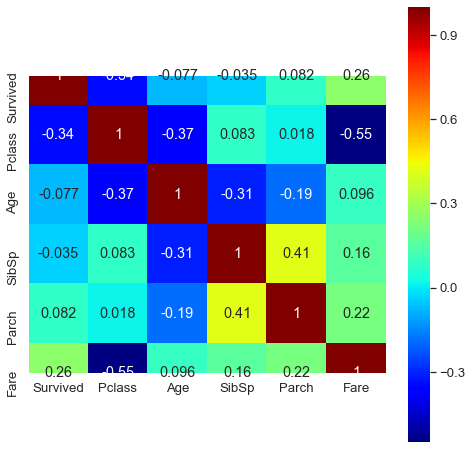

In [18]:
corrmat = train_data.corr()
seaborn.set(font_scale=1.2)
fig, axes = plt.subplots(figsize=(8,8))
sns.heatmap(corrmat, square=True, annot=True, cmap='jet')

In [18]:
# https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
# https://www.kaggle.com/gunesevitan/advanced-feature-engineering-tutorial-with-titanic
# https://www.kaggle.com/senasista/titanic-top-3-full-eda-model
# https://www.kaggle.com/omarelgabry/a-journey-through-titanic
# https://www.kaggle.com/ash316/eda-to-prediction-dietanic
# https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
# https://www.kaggle.com/mjbahmani/a-comprehensive-ml-workflow-with-python
# https://www.kaggle.com/sinakhorami/titanic-best-working-classifier